In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

laptop = 'forgach1mar822'

In [2]:
pickle_dirstring = 'C:/Users/' + laptop + '/Downloads/Egyéb/PICKLE/bubi_data.p'
bubi_data_df = pd.read_pickle(pickle_dirstring)

pickle_dirstring = 'C:/Users/' + laptop + '/Downloads/Egyéb/PICKLE/station_data_dists.p'
station_data_df = pd.read_pickle(pickle_dirstring)

bubi_data_df['station_code'] = bubi_data_df.Start_station.str.slice(0,4)
bubi_data_df['station_code'] = bubi_data_df.station_code.astype('int').astype('str')
station_data_df['Station_id'] = station_data_df['Station_id'].astype('int').astype('str')

bubi_data_df.head(2)
station_data_df.head(2)
station_data_df.shape

,Berles_UID,Start_station,End_station,UID,Bike_number,Ticket,start_time,end_time,time,station_code
0,7367458,0709-Rumbach Sebestyén utca - BKK,0709-Rumbach Sebestyén utca - BKK,858994.0,86325.0,féléves bérlet – promóciós,2014-09-08 00:00:32,2014-09-08 00:01:34,0 days 00:01:02,709
4,7368289,0709-Rumbach Sebestyén utca - BKK,0709-Rumbach Sebestyén utca - BKK,858913.0,86405.0,féléves bérlet – promóciós,2014-09-08 06:55:50,2014-09-08 06:57:22,0 days 00:01:32,709


,District,Station_id,Station,Rack number,lat,lon,Start date,End date,Move date,Shutdown start,Shutdown end,geometry,height,tags_light_rail_dist,tags_railway_dist,tags_train_dist,tags_bus_dist,tags_tram_dist,tags_trolleybus_dist,tags_subway_dist,atm_dist,bank_dist,bar_dist,cafe_dist,cinema_dist,fast_food_dist,pharmacy_dist,post_office_dist,pub_dist,restaurant_dist,theatre_dist,nearest_bubi_dist,bubi_stations_near,tags_light_rail_nearby,tags_railway_nearby,tags_train_nearby,tags_bus_nearby,tags_tram_nearby,tags_trolleybus_nearby,tags_subway_nearby,atm_nearby,bank_nearby,bar_nearby,cafe_nearby,cinema_nearby,fast_food_nearby,pharmacy_nearby,post_office_nearby,pub_nearby,restaurant_nearby,theatre_nearby
0,1.0,101,0101-Batthyány tér,28.0,47.506406,19.039172,2014-09-08,NaT,2015-01-15,2015-02-01,2015-04-22,POINT (19.03917 47.50641),97.0,40.0,52.0,1293.0,33.0,52.0,2026.0,58.0,16.0,107.0,454.0,100.0,574.0,89.0,121.0,110.0,166.0,85.0,776.0,334.0,0,4,5,0,4,2,0,2,5,2,0,3,0,2,2,1,4,6,0
1,1.0,102,0102-Szilágyi Dezső tér,15.0,47.503424,19.039714,2014-09-08,NaT,NaT,NaT,NaT,POINT (19.03971 47.50342),106.0,318.0,129.0,1157.0,300.0,129.0,1795.0,362.0,245.0,300.0,134.0,137.0,389.0,311.0,327.0,420.0,147.0,34.0,619.0,334.0,0,0,4,0,0,4,0,0,2,0,1,3,0,0,0,0,2,9,0


(159, 51)

### Célváltozók feature importance számításhoz

Bubi bérlések száma célváltozó megalkotása

In [78]:
bubi_data_df['station_year_month'] = bubi_data_df["station_code"] + "-" + bubi_data_df['start_time'].dt.strftime('%Y-%m').astype(str)

## Creating temp df
temp_count_df = pd.DataFrame(bubi_data_df['start_time'].groupby([bubi_data_df.station_year_month]).agg('count'))
temp_count_df = temp_count_df.reset_index()

temp_count_df['station_year_month'] = temp_count_df['station_year_month'].str.slice(0, -8)

## Create final list of stations with count of active months
station_activemonth_df = pd.DataFrame(temp_count_df.groupby([temp_count_df.station_year_month]).agg('count'))
station_activemonth_df = station_activemonth_df.rename({'start_time': 'active_month_count'}, axis=1)
station_activemonth_df.reset_index()
station_activemonth_df.head()

station_data_df = pd.merge(station_data_df, station_activemonth_df, left_on='Station_id',right_on='station_year_month')
station_data_df.head(2)

Wall time: 57.1 s


,District,Station_id,Station,Rack number,lat,lon,Start date,End date,Move date,Shutdown start,Shutdown end,geometry,height,tags_light_rail_dist,tags_railway_dist,tags_train_dist,tags_bus_dist,tags_tram_dist,tags_trolleybus_dist,tags_subway_dist,atm_dist,bank_dist,bar_dist,cafe_dist,cinema_dist,fast_food_dist,pharmacy_dist,post_office_dist,pub_dist,restaurant_dist,theatre_dist,nearest_bubi_dist,bubi_stations_near,tags_light_rail_nearby,tags_railway_nearby,tags_train_nearby,tags_bus_nearby,tags_tram_nearby,tags_trolleybus_nearby,tags_subway_nearby,atm_nearby,bank_nearby,bar_nearby,cafe_nearby,cinema_nearby,fast_food_nearby,pharmacy_nearby,post_office_nearby,pub_nearby,restaurant_nearby,theatre_nearby,active_month_count
0,1.0,101,0101-Batthyány tér,28.0,47.506406,19.039172,2014-09-08,NaT,2015-01-15,2015-02-01,2015-04-22,POINT (19.03917 47.50641),97.0,40.0,52.0,1293.0,33.0,52.0,2026.0,58.0,16.0,107.0,454.0,100.0,574.0,89.0,121.0,110.0,166.0,85.0,776.0,334.0,0,4,5,0,4,2,0,2,5,2,0,3,0,2,2,1,4,6,0,69
1,1.0,102,0102-Szilágyi Dezső tér,15.0,47.503424,19.039714,2014-09-08,NaT,NaT,NaT,NaT,POINT (19.03971 47.50342),106.0,318.0,129.0,1157.0,300.0,129.0,1795.0,362.0,245.0,300.0,134.0,137.0,389.0,311.0,327.0,420.0,147.0,34.0,619.0,334.0,0,0,4,0,0,4,0,0,2,0,1,3,0,0,0,0,2,9,0,69


In [81]:
## Create record count for each station
bubi_start_recordcount_df = pd.DataFrame(bubi_data_df.groupby(['station_code']).size())
bubi_start_recordcount_df = bubi_start_recordcount_df.rename(columns = {0:'Start_count'})
#

bubi_end_recordcount_df = pd.DataFrame(bubi_data_df.groupby(['End_station']).size())
bubi_end_recordcount_df = bubi_end_recordcount_df.rename(columns = {0:'End_count'})
#bubi_end_recordcount_df.head()


station_data_df = pd.merge(station_data_df, bubi_start_recordcount_df, left_on='Station_id',right_on='station_code')

#Drop not used columns
station_data_df['Usage_per_month'] = station_data_df['Start_count'] / station_data_df['active_month_count']
station_data_df = station_data_df.drop(['Start_count', 'active_month_count'], axis=1)
station_data_df.shape
station_data_df.head(2)

Wall time: 578 ms


,District,Station_id,Station,Rack number,lat,lon,Start date,End date,Move date,Shutdown start,Shutdown end,geometry,height,tags_light_rail_dist,tags_railway_dist,tags_train_dist,tags_bus_dist,tags_tram_dist,tags_trolleybus_dist,tags_subway_dist,atm_dist,bank_dist,bar_dist,cafe_dist,cinema_dist,fast_food_dist,pharmacy_dist,post_office_dist,pub_dist,restaurant_dist,theatre_dist,nearest_bubi_dist,bubi_stations_near,tags_light_rail_nearby,tags_railway_nearby,tags_train_nearby,tags_bus_nearby,tags_tram_nearby,tags_trolleybus_nearby,tags_subway_nearby,atm_nearby,bank_nearby,bar_nearby,cafe_nearby,cinema_nearby,fast_food_nearby,pharmacy_nearby,post_office_nearby,pub_nearby,restaurant_nearby,theatre_nearby,Usage_per_month
0,1.0,101,0101-Batthyány tér,28.0,47.506406,19.039172,2014-09-08,NaT,2015-01-15,2015-02-01,2015-04-22,POINT (19.03917 47.50641),97.0,40.0,52.0,1293.0,33.0,52.0,2026.0,58.0,16.0,107.0,454.0,100.0,574.0,89.0,121.0,110.0,166.0,85.0,776.0,334.0,0,4,5,0,4,2,0,2,5,2,0,3,0,2,2,1,4,6,0,728.594203
1,1.0,102,0102-Szilágyi Dezső tér,15.0,47.503424,19.039714,2014-09-08,NaT,NaT,NaT,NaT,POINT (19.03971 47.50342),106.0,318.0,129.0,1157.0,300.0,129.0,1795.0,362.0,245.0,300.0,134.0,137.0,389.0,311.0,327.0,420.0,147.0,34.0,619.0,334.0,0,0,4,0,0,4,0,0,2,0,1,3,0,0,0,0,2,9,0,348.188406


In [83]:
station_data_df.Usage_per_month.describe()

count     159.000000
mean      311.988669
std       223.406002
min        29.600000
25%       137.713218
50%       252.403226
75%       418.218310
max      1111.774648
Name: Usage_per_month, dtype: float64

## Normálás

In [4]:
#independent columns
X = station_data_df.iloc[:,3:(len(station_data_df.columns)-1)]
X = X.drop(['lat', 'lon', 'Start date', 'End date', 'Move date', 'Shutdown start', 'Shutdown end', 'geometry', 'Rack number'], axis = 1)
X.head()
X.shape

#target column
y = station_data_df.iloc[:,-1] 

,height,tags_light_rail_dist,tags_railway_dist,tags_train_dist,tags_bus_dist,tags_tram_dist,tags_trolleybus_dist,tags_subway_dist,atm_dist,bank_dist,bar_dist,cafe_dist,cinema_dist,fast_food_dist,pharmacy_dist,post_office_dist,pub_dist,restaurant_dist,theatre_dist,nearest_bubi_dist,bubi_stations_near,tags_light_rail_nearby,tags_railway_nearby,tags_train_nearby,tags_bus_nearby,tags_tram_nearby,tags_trolleybus_nearby,tags_subway_nearby,atm_nearby,bank_nearby,bar_nearby,cafe_nearby,cinema_nearby,fast_food_nearby,pharmacy_nearby,post_office_nearby,pub_nearby,restaurant_nearby,theatre_nearby
0,97.0,40.0,52.0,1293.0,33.0,52.0,2026.0,58.0,16.0,107.0,454.0,100.0,574.0,89.0,121.0,110.0,166.0,85.0,776.0,334.0,0,4,5,0,4,2,0,2,5,2,0,3,0,2,2,1,4,6,0
1,106.0,318.0,129.0,1157.0,300.0,129.0,1795.0,362.0,245.0,300.0,134.0,137.0,389.0,311.0,327.0,420.0,147.0,34.0,619.0,334.0,0,0,4,0,0,4,0,0,2,0,1,3,0,0,0,0,2,9,0
2,110.0,972.0,47.0,1158.0,28.0,47.0,1453.0,700.0,102.0,563.0,445.0,38.0,542.0,520.0,302.0,146.0,151.0,32.0,768.0,533.0,0,0,2,0,3,2,0,0,3,0,0,9,0,0,0,1,2,10,0
3,108.0,1728.0,109.0,1695.0,117.0,109.0,1055.0,702.0,453.0,622.0,518.0,39.0,951.0,569.0,725.0,799.0,24.0,28.0,649.0,591.0,0,0,6,0,4,6,0,0,0,0,0,1,0,0,0,0,1,1,0
4,126.0,1218.0,69.0,69.0,64.0,115.0,2639.0,104.0,57.0,132.0,794.0,21.0,750.0,29.0,116.0,65.0,66.0,37.0,1305.0,523.0,0,0,20,12,8,6,0,2,3,1,0,2,0,6,2,1,2,5,0


(159, 39)

In [5]:
feature_cols = X.columns

scaler = MinMaxScaler()
# fit and transform the data
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X.head(2)

,height,tags_light_rail_dist,tags_railway_dist,tags_train_dist,tags_bus_dist,tags_tram_dist,tags_trolleybus_dist,tags_subway_dist,atm_dist,bank_dist,bar_dist,cafe_dist,cinema_dist,fast_food_dist,pharmacy_dist,post_office_dist,pub_dist,restaurant_dist,theatre_dist,nearest_bubi_dist,bubi_stations_near,tags_light_rail_nearby,tags_railway_nearby,tags_train_nearby,tags_bus_nearby,tags_tram_nearby,tags_trolleybus_nearby,tags_subway_nearby,atm_nearby,bank_nearby,bar_nearby,cafe_nearby,cinema_nearby,fast_food_nearby,pharmacy_nearby,post_office_nearby,pub_nearby,restaurant_nearby,theatre_nearby
0,0.016949,0.000895,0.054945,0.402045,0.056437,0.039845,0.483723,0.018104,0.011455,0.080498,0.173947,0.086408,0.220332,0.133005,0.137143,0.062057,0.151631,0.088071,0.327281,0.302297,0.0,1.0,0.25,0.0,0.148148,0.2,0.0,0.333333,0.357143,0.181818,0.000000,0.111111,0.0,0.071429,0.5,0.5,0.2,0.139535,0.0
1,0.169492,0.083856,0.148962,0.358581,0.527337,0.114674,0.428020,0.126021,0.273769,0.240664,0.048013,0.122330,0.143568,0.497537,0.431429,0.336879,0.133397,0.031215,0.259403,0.302297,0.0,0.0,0.20,0.0,0.000000,0.4,0.0,0.000000,0.142857,0.000000,0.030303,0.111111,0.0,0.000000,0.0,0.0,0.1,0.209302,0.0


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)

In [7]:
X.shape
X_train.shape
X_test.shape

(159, 39)

(31, 39)

(128, 39)

### Random forest base model

In [8]:
from sklearn.ensemble import RandomForestRegressor
import pickle

rf_base = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf_base.fit(X_train, y_train)
#filename = 'random_forest_1.sav'
#pickle.dump(rf, open(filename, 'wb'))

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf_base.score(X_train, y_train), 
                                                                                             rf_base.oob_score_,
                                                                                             rf_base.score(X_test, y_test)))

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

R^2 Training Score: 0.89 
OOB Score: 0.23 
R^2 Validation Score: -0.00


In [9]:
from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_base.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [10]:
#base_accuracy = evaluate(rf, X_test, y_test)
y_pred = rf_base.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  

Mean Squared Error: 44135.438067025316


### GRID SEARCH

In [11]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 3, 5, 8], #default 80, 90, 100, 110,
    'max_features': ['sqrt'], #default 2,3
    #'min_samples_leaf': [1, 2, 3, 4, 5], #default 3, 4, 5
    'min_samples_split': [10, 20, 50], #default 8, 10, 12
    'n_estimators': [50, 100, 200, 500] #default 100, 200, 300, 1000
}

# Create a base model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'neg_mean_squared_error',
                          cv = 5, n_jobs = -1, verbose = 2, return_train_score=True)

In [12]:
# Fit the grid search to the data_search.best_params_
grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Wall time: 25.7 s


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [2, 3, 5, 8],
                         'max_features': ['sqrt'],
                         'min_samples_split': [10, 20, 50],
                         'n_estimators': [50, 100, 200, 500]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [13]:
grid_search.best_params_
best_params = grid_search.best_params_
#best_params.keys()
#best_params.values()

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 50}

In [19]:
gridsearch_best_rf=RandomForestRegressor(bootstrap = list(best_params.values())[0], 
                                         max_depth = list(best_params.values())[1], 
                                         max_features = list(best_params.values())[2], 
                                         min_samples_split = list(best_params.values())[3], 
                                         n_estimators = list(best_params.values())[4],
                                         oob_score = True,
                                         random_state = 42)

gridsearch_best_rf.fit(X_train, y_train)
y_pred=gridsearch_best_rf.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('R2 score:', r2_score(y_test, y_pred))
print('OOB score: ', gridsearch_best_rf.oob_score_)

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=10,
                      n_estimators=50, oob_score=True, random_state=42)

Mean Squared Error: 39358.52065667116
R2 score: 0.10626001826620812
OOB score:  0.17303140042983267


## BEST RF CHOSEN

In [20]:
gridsearch_best_rf = RandomForestRegressor(max_depth=2, max_features='sqrt', min_samples_split=10, n_estimators=50, random_state=42)
gridsearch_best_rf.fit(X_train, y_train)
filename = 'random_forest_gridCV_best.sav'
pickle.dump(gridsearch_best_rf, open(filename, 'wb'))

RandomForestRegressor(max_depth=2, max_features='sqrt', min_samples_split=10,
                      n_estimators=50, random_state=42)

In [32]:
sorted(list(zip(gridsearch_best_rf.feature_importances_, X.columns)), key=lambda x: abs(x[0]), reverse=True)[:10]

[(0.10871312907518915, 'restaurant_dist'),
 (0.09261551646310724, 'tags_subway_dist'),
 (0.08345370826582812, 'theatre_dist'),
 (0.07880027124270123, 'tags_subway_nearby'),
 (0.07206016194433035, 'pub_nearby'),
 (0.06672679007377423, 'tags_tram_dist'),
 (0.05603734878476741, 'bank_dist'),
 (0.03793993740955531, 'tags_train_dist'),
 (0.03591419475600327, 'height'),
 (0.03394557881539256, 'bar_dist')]

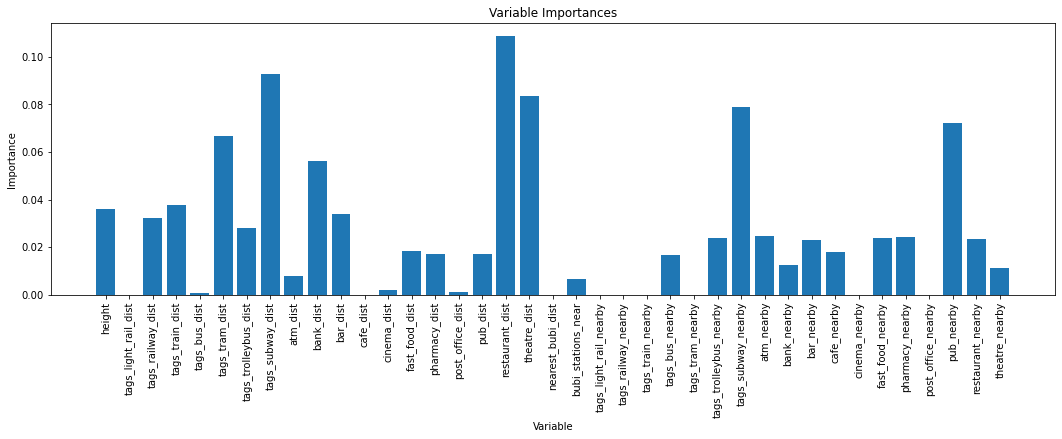

In [31]:
sorted(list(zip(gridsearch_best_rf.feature_importances_, X.columns)), key=lambda x: abs(x[0]), reverse=True)[:10]

importances = list(gridsearch_best_rf.feature_importances_)

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
f, ax = plt.subplots(figsize=(18,5))
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
feature_list = list(X.columns)
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
#plt.savefig("variable_importance.png");

In [35]:
from keplergl import KeplerGl
map = KeplerGl(height=500)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [36]:
map.add_data(data=station_data_df[['lon','lat', 'Usage_per_month']], name="current stations")

In [37]:
map.config = {'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 47.508314,
   'longitude': 19.062772,
   'pitch': 0,
   'zoom': 11.455802145811225,
   'isSplit': False}}

map.save_to_html(file_name="current_stations.html")

Map saved to current_stations.html!
